In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

sns.set_palette('Set1')

In [2]:
def hist_equalize(matrix):
    matrix = np.copy(matrix)
    shape = matrix.shape
    matrix = matrix.reshape(-1)
    index = matrix.argsort()
    values = np.linspace(0, 1, index.shape[0])
    matrix[index] = values
    return matrix.reshape(shape)

def mkrdm(data):
    rdmat = 1 - cosine_similarity(data)
    return rdmat

def mkherdm(data):
    rdmat = 1 - cosine_similarity(data)
    return hist_equalize(rdmat)

In [3]:
def movavg(inp, bl, ss):
    nbin = int(np.floor((inp.shape[2] - bl) / ss))
    out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
    for ibin in range(nbin):
        out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
    return out

itc = movavg(np.load('G:\Data\Fast\Both\ITCNoAvg.npy'), 25, 1)
pfc = movavg(np.load('G:\Data\Fast\Both\PFCNoAvg.npy'), 25, 1)

In [4]:
rdm_data = {}
for region, attr in zip(['itc', 'pfc'], [itc, pfc]):
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "A") | (info.sfr == "BI"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(
        info.con.astype('category').cat.set_categories(
            ['human face', 'monkey face', 'human body', 'monkey body', 'artificial', 'natural'], 
            ordered=True
        )
    )
    rdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])
    herdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])

    for itime in range(attr.shape[2]):
        rdmat[:,:,itime] = mkrdm(attr[argsort, :, itime])
        herdmat[:,:,itime] = mkherdm(attr[argsort, :, itime])

    rdm_data[region] = {'raw': rdmat, 'histeq': herdmat}

# CORNet-Z

In [ ]:
rdm_cornet = {}
for region in ['V1', 'V2', 'V4', 'IT']:
    attr = np.load(f'CORnet-Z_{region}_output_feats.npy')
    attr = attr[:165, :]
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "A") | (info.sfr == "BI"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(
        info.con.astype('category').cat.set_categories(
            ['human face', 'monkey face', 'human body', 'monkey body', 'artificial', 'natural'], 
            ordered=True
        )
    )
    rdmat = mkrdm(attr[argsort, :])
    herdmat = mkherdm(attr[argsort, :])

    rdm_cornet[region] = {'raw': rdmat, 'histeq': herdmat}

In [ ]:
cm = 1/2.54
fig, axs = plt.subplots(1,1,figsize=(5*cm, 5*cm), dpi=200)
ax = axs
ax.imshow(rdm_cornet['IT']['histeq'])
ax.axis('off')

In [ ]:
from scipy.stats import kendalltau as tau
from scipy.stats import pearsonr as p
from scipy.stats import spearmanr as r

cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm , 6 * cm), dpi=200)

tim = np.arange(-200, 675) + 12.5

for ax, region in zip(axs.flat, rdm_data.keys()):
    for cnet in ['V1', 'V4', 'IT']: #rdm_cornet.keys():
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        _s = []
        for time in range(X.shape[2]):
            _s.append(p(X[:, :, time].flatten(), y.flatten())[0])
        _s = np.array(_s)

        ax.plot(tim, _s-_s[(tim >= -25) & (tim < 25)].mean(), label=cnet)
        # ax.plot(tim, _s, label=cnet)
    ax.set_title(region)
    ax.legend(frameon=False)
fig.tight_layout()
sns.despine()

plt.savefig('z-p.pdf')

# CORNet-S

In [5]:
rdm_cornet = {}
for region in ['V1', 'V2', 'V4', 'IT']:
    attr = np.load(f'CORnet-S_{region}_output_feats.npy')
    attr = attr[:165, :]
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "A") | (info.sfr == "BI"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(
        info.con.astype('category').cat.set_categories(
            ['human face', 'monkey face', 'human body', 'monkey body', 'artificial', 'natural'], 
            ordered=True
        )
    )
    rdmat = mkrdm(attr[argsort, :])
    herdmat = mkherdm(attr[argsort, :])

    rdm_cornet[region] = {'raw': rdmat, 'histeq': herdmat}

In [ ]:
cm = 1/2.54

for reg in rdm_cornet.keys():
    fig, ax = plt.subplots(1,1,figsize=(5*cm, 5*cm), dpi=200)
    ax.imshow(rdm_cornet[reg]['histeq'])
    # ax.set_title(reg, fontsize=5)
    ax.axis('off')

    fig.tight_layout()

    plt.savefig(f"cornet-s-{reg}-rdms.pdf")
    plt.close()

In [56]:
from scipy.stats import kendalltau as tau
from scipy.stats import pearsonr as p
from scipy.stats import spearmanr as r
from tqdm.notebook import tqdm

corr = {'itc': {'V1': [], 'V2': [], 'V4': [], 'IT': []},
        'pfc': {'V1': [], 'V2': [], 'V4': [], 'IT': []},
        'itc0': {'V1': [], 'V2': [], 'V4': [], 'IT': []},
        'pfc0': {'V1': [], 'V2': [], 'V4': [], 'IT': []}
}

for region in ['itc', 'pfc']:
    for cnet in ['V1', 'V2', 'V4', 'IT']:
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        for time in range(X.shape[2]):
            corr[region][cnet].append(p(X[:, :, time].flatten(), y.flatten())[0])
        corr[region][cnet] = np.array(corr[region][cnet])

        for ishuffle in tqdm(range(100)):
            np.range.seed(ishuffle)
            shufind = np.random.permutation(X.shape[0]).flatten()
            X = X[shufind][:, shufind]
            _s = []
            for time in range(X.shape[2]):
                _s.append(p(X[:, :, time].flatten(), y.flatten())[0])
            corr[region+"0"][cnet].append(_s)
        corr[region+"0"][cnet] = np.array(corr[region+"0"][cnet])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.027899210974094493 -0.027899210974094493
0.029379469016859602 -0.029379469016859595


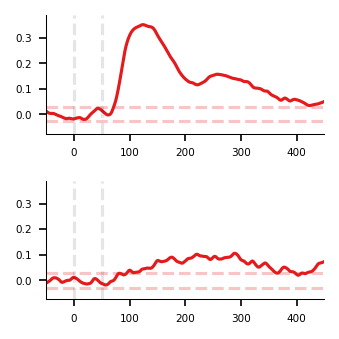

In [152]:
from scipy.ndimage import gaussian_filter1d as smooth

cm = 1 / 2.54
fig, axs = plt.subplots(2, 1, figsize=(6 * cm , 6 * cm), dpi=150, sharey=True)

tim = np.arange(-200, 675) + 12.5

for ax, region, sig in zip(axs.flat, ['itc', 'pfc'], [2.5, 2.5]):
    # for cnet in ['V1', 'V2', 'V4', 'IT']:
    for cnet in ['IT']:
        c = corr[region][cnet]
        c0 = corr[region+"0"][cnet]
        Z = smooth((c - c0.mean(0)), sigma=sig)
        Z -= Z[tim<0].mean()
        print(3 * Z[tim<0].std() + Z[tim<0].mean(), -3 * Z[tim<0].std() + Z[tim<0].mean())
        # h = ax.plot(tim, Z - Z[(tim < 25) & (tim > -25)].mean(), label=cnet.upper())
        h = ax.plot(tim, Z - Z[(tim < 0)].mean(), label=cnet.upper())
        ax.axhline(Z[tim<0].mean() + Z[tim<0].std() * 3, c=h[0].get_color(), ls='--', alpha=.25)
        ax.axhline(Z[tim<0].mean() - Z[tim<0].std() * 3, c=h[0].get_color(), ls='--', alpha=.25)
        ax.axvline(0, c='k', ls='--', alpha=.1)
        ax.axvline(50, c='k', ls='--', alpha=.1)
        ax.set_xlim(-50, 450)
        ax.set_ylim(-.075, .39)
        # ax.set_title(region)
        # ax.legend(frameon=False)

        ax.tick_params(axis='both', which='major', labelsize=5)
        plt.setp(ax.spines.values(), linewidth=.5)
        # ax.set_yticks(ax.get_xticks())

sns.despine()
fig.tight_layout()
plt.savefig("cornet-correlation.pdf")

In [115]:
h[0].get_color()

(0.596078431372549, 0.3058823529411765, 0.6392156862745098)

In [ ]:
from scipy.stats import kendalltau as tau
from scipy.stats import pearsonr as p
from scipy.stats import spearmanr as r

cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm , 6 * cm), dpi=200)

tim = np.arange(-200, 675) + 12.5


for ax, region in zip(axs.flat, rdm_data.keys()):
    for cnet in ['V1', 'V4', 'IT']: #rdm_cornet.keys():
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        _s = []
        for time in range(X.shape[2]):
            _s.append(p(X[:, :, time].flatten(), y.flatten())[0])
        _s = np.array(_s)

        # ax.plot(tim, _s-_s[(tim >= -25) & (tim < 25)].mean(), label=cnet)
        ax.plot(tim, _s, label=cnet)
        ax.set_xlim(-50, 450)
    ax.set_title(region)
    ax.legend(frameon=False)

sns.despine()
fig.tight_layout()

# plt.savefig('s-p.pdf')

In [ ]:
rdm_cornet = {}
for region in ['V1', 'V2', 'V4', 'IT']:
    attr = np.load(f'CORnet-S_{region}_output_feats.npy')
    attr = attr[:165, :]
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "BL"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = mkrdm(attr[argsort, :])
    herdmat = mkherdm(attr[argsort, :])

    rdm_cornet[region] = {'raw': rdmat, 'histeq': herdmat}

In [ ]:
rdm_data = {}
for region, attr in zip(['itc', 'pfc'], [itc, pfc]):
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & (info.sfr == "BL")).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])
    herdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])

    for itime in range(attr.shape[2]):
        rdmat[:,:,itime] = mkrdm(attr[argsort, :, itime])
        herdmat[:,:,itime] = mkherdm(attr[argsort, :, itime])

    rdm_data[region] = {'raw': rdmat, 'histeq': herdmat}

In [ ]:
from scipy.stats import kendalltau as tau

cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm , 6 * cm), dpi=200)

tim = np.arange(-200, 675) + 12.5

for ax, region in zip(axs.flat, rdm_data.keys()):
    for cnet in rdm_cornet.keys():
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        _s = []
        for time in range(X.shape[2]):
            _s.append(tau(X[:, :, time].flatten(), y.flatten())[0])
        _s = np.array(_s)

        ax.plot(tim, _s, label=cnet)
    ax.set_title(region)
    ax.legend(frameon=False)
fig.tight_layout()
sns.despine()

In [ ]:
rdm_cornet = {}
for region in ['V1', 'V2', 'V4', 'IT']:
    attr = np.load(f'CORnet-S_{region}_output_feats.npy')
    attr = attr[:165, :]
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "BH"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = mkrdm(attr[argsort, :])
    herdmat = mkherdm(attr[argsort, :])

    rdm_cornet[region] = {'raw': rdmat, 'histeq': herdmat}

In [ ]:
rdm_data = {}
for region, attr in zip(['itc', 'pfc'], [itc, pfc]):
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & (info.sfr == "BH")).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])
    herdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])

    for itime in range(attr.shape[2]):
        rdmat[:,:,itime] = mkrdm(attr[argsort, :, itime])
        herdmat[:,:,itime] = mkherdm(attr[argsort, :, itime])

    rdm_data[region] = {'raw': rdmat, 'histeq': herdmat}

In [ ]:
from scipy.stats import kendalltau as tau

cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm , 6 * cm), dpi=200)

tim = np.arange(-200, 675) + 12.5

for ax, region in zip(axs.flat, rdm_data.keys()):
    for cnet in rdm_cornet.keys():
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        _s = []
        for time in range(X.shape[2]):
            _s.append(tau(X[:, :, time].flatten(), y.flatten())[0])
        _s = np.array(_s)

        ax.plot(tim, _s, label=cnet)
    ax.set_title(region)
    ax.legend(frameon=False)
fig.tight_layout()
sns.despine()

# CORNet-RT

In [ ]:
rdm_cornet = {}
for region in ['V1', 'V2', 'V4', 'IT']:
    attr = np.load(f'CORnet-RT_{region}_output_feats.npy')
    attr = attr[:165, :]
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "A") | (info.sfr == "BI"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(
        info.con.astype('category').cat.set_categories(
            ['human face', 'monkey face', 'human body', 'monkey body', 'artificial', 'natural'], 
            ordered=True
        )
    )
    rdmat = mkrdm(attr[argsort, :])
    herdmat = mkherdm(attr[argsort, :])

    rdm_cornet[region] = {'raw': rdmat, 'histeq': herdmat}

In [ ]:
cm = 1/2.54
fig, axs = plt.subplots(1,1,figsize=(5*cm, 5*cm), dpi=200)
ax = axs
ax.imshow(rdm_cornet['IT']['histeq'])
ax.axis('off')

In [ ]:
from scipy.stats import kendalltau as tau
from scipy.stats import pearsonr as p
from scipy.stats import spearmanr as r

cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm , 6 * cm), dpi=200)

tim = np.arange(-200, 675) + 12.5

for ax, region in zip(axs.flat, rdm_data.keys()):
    for cnet in ['V1', 'V4', 'IT']: #rdm_cornet.keys():
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        _s = []
        for time in range(X.shape[2]):
            _s.append(tau(X[:, :, time].flatten(), y.flatten())[0])
        _s = np.array(_s)

        # ax.plot(tim, _s, label=cnet)
        ax.plot(tim, _s-_s[(tim >= -25) & (tim < 25)].mean(), label=cnet)
    ax.set_title(region)
    ax.legend(frameon=False)
fig.tight_layout()
sns.despine()

plt.savefig('rt-tau.pdf')